# GAN Monet
### Author: Blu LeBlanc
https://github.com/Blu-LeBlanc/Deep-Learning-Projects

The goal of this project is to use generative adversial networks (GAN) to mimic the work of the famous artist Claude Monet. The task is to build a GAN that generates 7,000 to 10,000 Monet-style images. My submission will be evaluated with the MiFID metric. The smaller MiFID is, the better my generated images are

In [1]:
# Load Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn

# TPU setup
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl

/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


## Data
The dataset consists of four files: 

- monet_jpg: 300 Monet paintings size 256x256 in JPEG format
- monet_tfrec: 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg: 7028 photos sized 256x256 in JPEG format
- 7028 photos sized 256x256 in TFRecord format

## Exploratory Data Analysis
Let's create an object to transform our data and set up our train and test split. We will preprocess and pair up our monet image and photo image. After the transformation, we will view samples of our training data

E0000 00:00:1753803353.321001      74 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:232


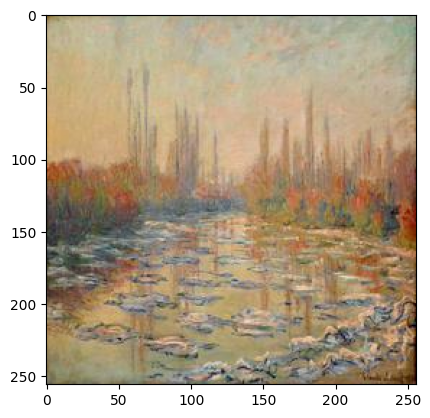

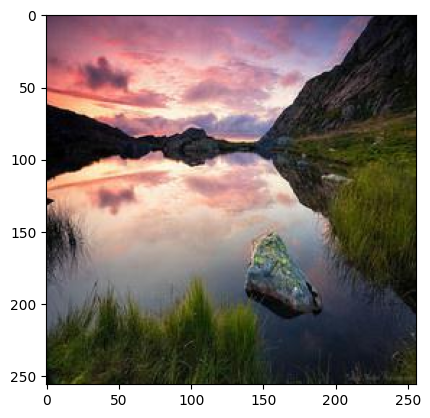

In [2]:
# Use TPU for running models
device = xm.xla_device()

data_root = '/kaggle/input/gan-getting-started/'
monet_path, photo_path = 'monet_jpg', 'photo_jpg'

class MonetPhoto(Dataset):
    def __init__(self, data_root, monet_path, photo_path, transform=None):
        self.monet_images = os.listdir(os.path.join(data_root, monet_path))
        self.photo_images = os.listdir(os.path.join(data_root, photo_path))
        self.transform = transform

    def __len__(self):
        return max(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx):
        monet_image = Image.open(os.path.join(data_root, monet_path, self.monet_images[idx % len(self.monet_images)]))
        photo_image = Image.open(os.path.join(data_root, photo_path, self.photo_images[idx % len(self.photo_images)]))
        if self.transform:
            monet_image, photo_image = self.transform(monet_image), self.transform(photo_image)
        return monet_image, photo_image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

dataset = MonetPhoto(data_root, monet_path, photo_path, transform=transform)
train_size = int(0.8 * len(dataset))
train_data, test_data = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader_base = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader_base = DataLoader(test_data, batch_size=32, shuffle=True)
# Wrap with TPU loader
train_loader = pl.MpDeviceLoader(train_loader_base, device)
test_loader = pl.MpDeviceLoader(test_loader_base, device)

monet_sample, photo_sample = next(iter(train_loader))
plt.imshow(monet_sample[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.show()
plt.imshow(photo_sample[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.show()


I also want to view our distribution of data

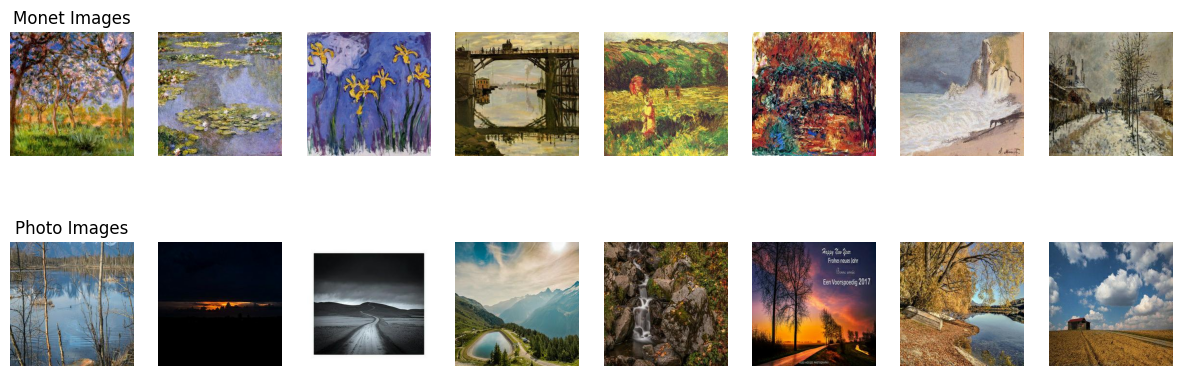

In [3]:
def plot_image_grid(loader, num_images=8):
    fig, ax = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        monet_image, photo_image = next(iter(loader))
        ax[0, i].imshow(monet_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        ax[0, i].axis('off')
        ax[1, i].imshow(photo_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        ax[1, i].axis('off')

    ax[0, 0].set_title('Monet Images')
    ax[1, 0].set_title('Photo Images')

    plt.show()

# Call the function to plot the image grid
plot_image_grid(train_loader_base)

## Model Architecture
A GAN consists of at minimum two neural networks: a generator model and a discriminator model. The generator is a neural network that creates images in the style of Monet. The discriminator is another neural network trying to accurately classify the real vs generated images. The goal is for the discriminator to train and improve the generator. Let's create our model architecture

In [4]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256]):
        super().__init__()
        self.model = nn.Sequential(
            CNNBlock(in_channels, features[0], 2),
            CNNBlock(features[0], features[1], 2),
            CNNBlock(features[1], features[2], 2),
            nn.Conv2d(features[2], 1, 4, padding=1, padding_mode='reflect')
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.encoder = nn.Sequential(
            CNNBlock(in_channels, features, 2),
            CNNBlock(features, features * 2, 2),
            CNNBlock(features * 2, features * 4, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

For improving how models are generated, I used a separate CNNBlock object to guild my discriminator and generator.

## Analysis
Let's initialize our models and set up optimizing training techniques. I know that TPU can work efficiently with larger batch sizes.

In [5]:
# Need to change batch size for TPU
# Instantiate models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
criterion = nn.MSELoss()
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0008, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0008, betas=(0.5, 0.999))

d_losses = []
g_losses = []


num_epochs = 10
for epoch in range(num_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    num_batches = 0
    
    for real_monet, real_photo in train_loader:
        real_monet, real_photo = real_monet.to(device), real_photo.to(device)

        # discriminator
        optimizerD.zero_grad()
        
        fake_photo = generator(real_monet)
        real_loss = criterion(discriminator(real_photo), torch.ones_like(discriminator(real_photo)))
        fake_loss = criterion(discriminator(fake_photo.detach()), torch.zeros_like(discriminator(fake_photo.detach())))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizerD.step()
        xm.optimizer_step(optimizerD)

        # generator
        optimizerG.zero_grad()

        output = discriminator(fake_photo)
        g_loss = criterion(output, torch.ones_like(output))

        g_loss.backward()
        optimizerG.step()
        xm.optimizer_step(optimizerG)

        # Accumulate losses
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        num_batches += 1

    # Average losses for the epoch
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    

    print(f'Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    xm.mark_step()  # Ensure sync with TPU

Epoch [1/10] - D Loss: 0.5281, G Loss: 0.6941


Epoch [2/10] - D Loss: 0.0605, G Loss: 0.9659


Epoch [3/10] - D Loss: 0.0583, G Loss: 0.7244


Epoch [4/10] - D Loss: 0.1350, G Loss: 1.8869


Epoch [5/10] - D Loss: 0.0819, G Loss: 0.7543


Epoch [6/10] - D Loss: 0.0345, G Loss: 0.9966


Epoch [7/10] - D Loss: 0.0248, G Loss: 0.8261


Epoch [8/10] - D Loss: 0.0073, G Loss: 0.9675


Epoch [9/10] - D Loss: 0.1555, G Loss: 0.4525


Epoch [10/10] - D Loss: 0.0739, G Loss: 1.1995


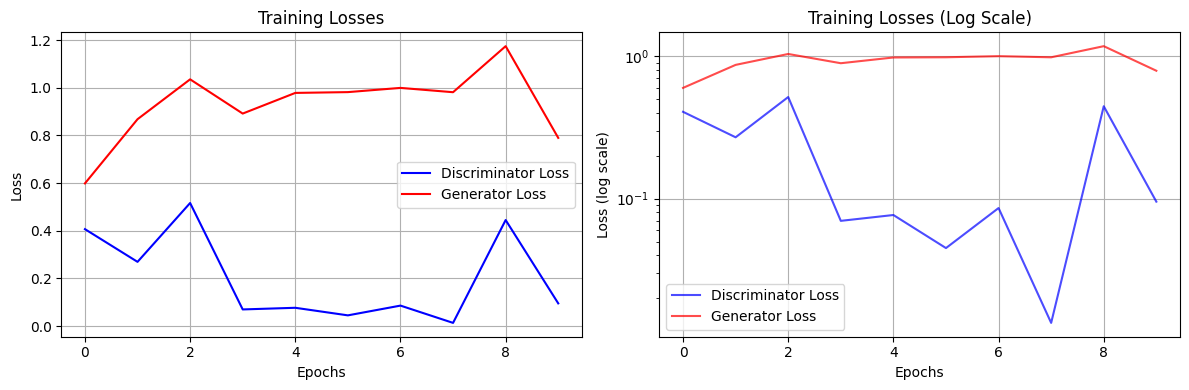

In [6]:
import matplotlib.pyplot as plt

# 1. Loss Curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss', color='blue')
plt.plot(g_losses, label='Generator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(d_losses, label='Discriminator Loss', color='blue', alpha=0.7)
plt.plot(g_losses, label='Generator Loss', color='red', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Losses (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

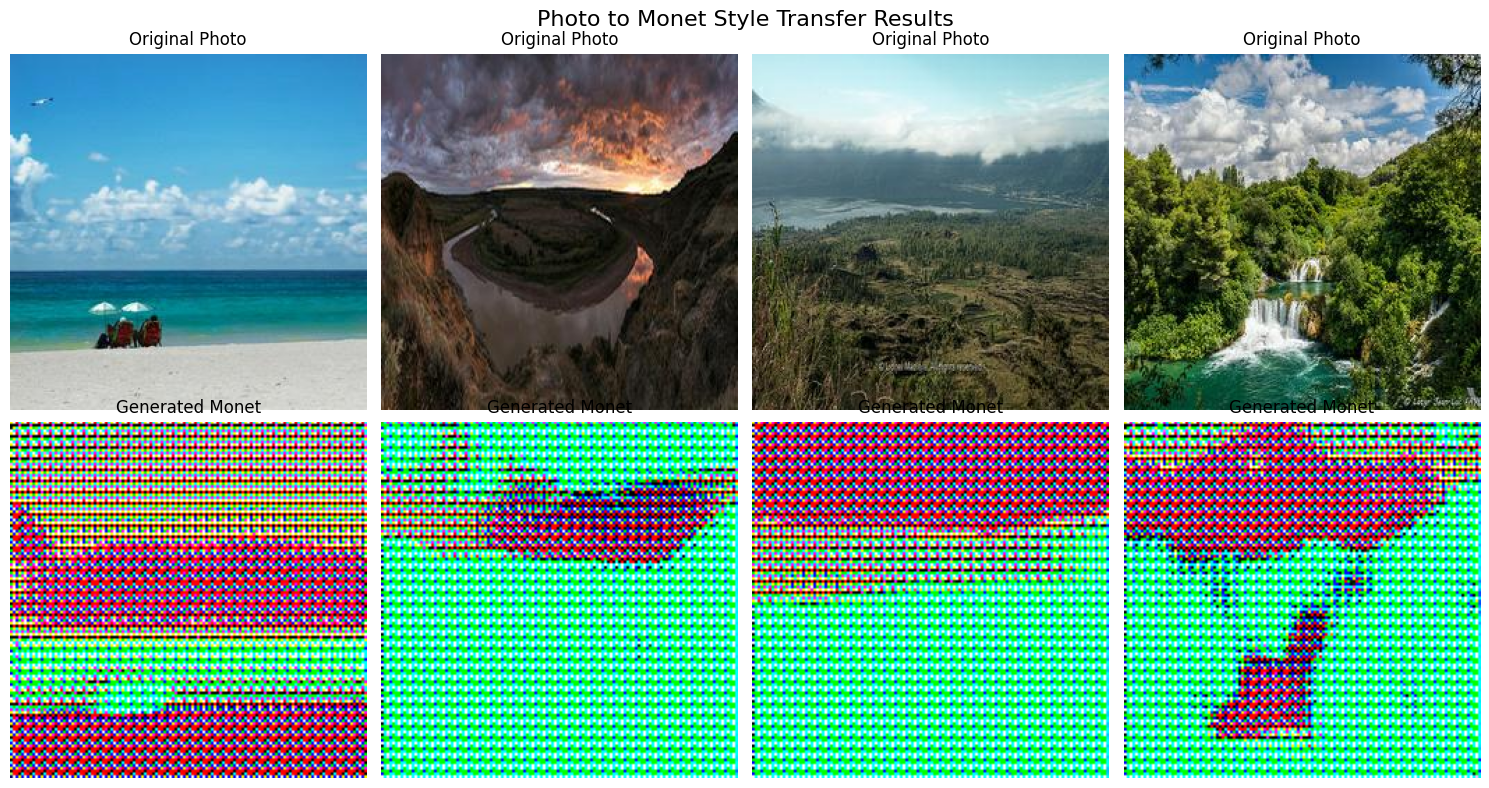

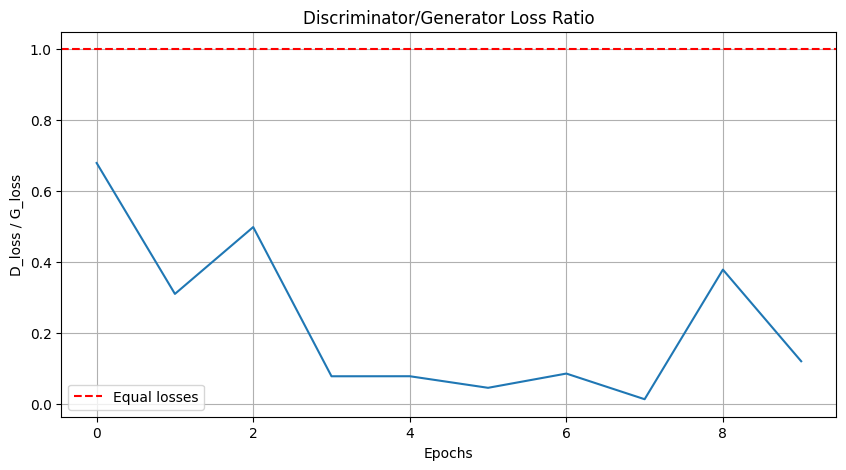

In [7]:
def visualize_results(generator, test_loader, device, num_samples=4):
    generator.eval()
    
    real_monet, real_photo = next(iter(test_loader))
    real_monet = real_monet[:num_samples].to(device)
    real_photo = real_photo[:num_samples].to(device)
    
    with torch.no_grad():
        fake_monet = generator(real_photo)
        xm.mark_step()
    
    # Move to CPU for visualization
    real_photo = real_photo.cpu()
    fake_monet = fake_monet.cpu()
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for i in range(num_samples):
        # Original photos
        axes[0, i].imshow(real_photo[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[0, i].set_title('Original Photo')
        axes[0, i].axis('off')
        
        # Generated Monet-style images
        axes[1, i].imshow(fake_monet[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[1, i].set_title('Generated Monet')
        axes[1, i].axis('off')
    
    plt.suptitle('Photo to Monet Style Transfer Results', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    generator.train()

# Call visualization after training
visualize_results(generator, test_loader, device)

# Loss Ratio Analysis (useful for GAN stability)
plt.figure(figsize=(10, 5))
loss_ratio = [d/g if g != 0 else 0 for d, g in zip(d_losses, g_losses)]
plt.plot(loss_ratio)
plt.xlabel('Epochs')
plt.ylabel('D_loss / G_loss')
plt.title('Discriminator/Generator Loss Ratio')
plt.axhline(y=1, color='r', linestyle='--', label='Equal losses')
plt.legend()
plt.grid(True)
plt.show()

There is something seriously wrong with my generated Monet images. When I look at my plots, I see that the generator loss is increasing and discriminator loss is decreasing. This means that the discriminator is winning too easily. To improve my model, I will improve the generator model architecture. I will also add learning rate scheduling.

### Improved Generator

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, 1, 1, padding_mode='reflect'),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, 3, 1, 1, padding_mode='reflect'),
            nn.InstanceNorm2d(in_channels),
        )

    def forward(self, x):
        return x + self.block(x)

class ImprovedGenerator(nn.Module):
    def __init__(self, in_channels=3, num_residual_blocks=9):
        super().__init__()
        
        # Initial convolution
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, 1, 3, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling
        self.down_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(64, 128, 3, 2, 1),
                nn.InstanceNorm2d(128),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(128, 256, 3, 2, 1),
                nn.InstanceNorm2d(256),
                nn.ReLU(inplace=True)
            )
        ])
        
        # Residual blocks
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(num_residual_blocks)]
        )
        
        # Upsampling
        self.up_blocks = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1),
                nn.InstanceNorm2d(128),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),
                nn.InstanceNorm2d(64),
                nn.ReLU(inplace=True)
            )
        ])
        
        # Output layer
        self.final = nn.Sequential(
            nn.Conv2d(64, in_channels, 7, 1, 3, padding_mode='reflect'),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        
        for down in self.down_blocks:
            x = down(x)
            
        x = self.res_blocks(x)
        
        for up in self.up_blocks:
            x = up(x)
            
        return self.final(x)

Redo my training with learning rate scheduling

In [9]:
# New training

from torch.optim.lr_scheduler import StepLR
generator = ImprovedGenerator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
criterion = nn.MSELoss()
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0008, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0008, betas=(0.5, 0.999))

schedulerG = StepLR(optimizerG, step_size=10, gamma=0.5)
schedulerD = StepLR(optimizerD, step_size=10, gamma=0.5)

d_losses = []
g_losses = []


num_epochs = 30
for epoch in range(num_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    num_batches = 0
    
    for real_monet, real_photo in train_loader:
        real_monet, real_photo = real_monet.to(device), real_photo.to(device)

        # discriminator
        optimizerD.zero_grad()
        
        fake_photo = generator(real_monet)
        real_loss = criterion(discriminator(real_photo), torch.ones_like(discriminator(real_photo)))
        fake_loss = criterion(discriminator(fake_photo.detach()), torch.zeros_like(discriminator(fake_photo.detach())))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
#        optimizerD.step()
        xm.optimizer_step(optimizerD)

        # generator
        optimizerG.zero_grad()

        output = discriminator(fake_photo)
        g_loss = criterion(output, torch.ones_like(output))

        g_loss.backward()
#        optimizerG.step()
        xm.optimizer_step(optimizerG)

        # Accumulate losses
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        num_batches += 1

    # Average losses for the epoch
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    
    # At the end of each epoch
    schedulerG.step()
    schedulerD.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    xm.mark_step()  # Ensure sync with TPU

Epoch [1/30] - D Loss: 0.2493, G Loss: 0.2915


Epoch [2/30] - D Loss: 0.1077, G Loss: 0.6452


Epoch [3/30] - D Loss: 0.0926, G Loss: 0.5874


Epoch [4/30] - D Loss: 0.0579, G Loss: 0.9197


Epoch [5/30] - D Loss: 0.0897, G Loss: 2.3953


Epoch [6/30] - D Loss: 0.0341, G Loss: 0.8891


Epoch [7/30] - D Loss: 0.0275, G Loss: 0.8978


Epoch [8/30] - D Loss: 0.0155, G Loss: 0.9525


Epoch [9/30] - D Loss: 0.0114, G Loss: 0.9618


Epoch [10/30] - D Loss: 0.0580, G Loss: 0.8237


Epoch [11/30] - D Loss: 0.1960, G Loss: 0.4182


Epoch [12/30] - D Loss: 0.2037, G Loss: 0.5433


Epoch [13/30] - D Loss: 0.2244, G Loss: 0.3949


Epoch [14/30] - D Loss: 0.1959, G Loss: 0.4554


Epoch [15/30] - D Loss: 0.2117, G Loss: 0.4539


Epoch [16/30] - D Loss: 0.1612, G Loss: 0.4688


Epoch [17/30] - D Loss: 0.2417, G Loss: 0.4909


Epoch [18/30] - D Loss: 0.2573, G Loss: 0.4157


Epoch [19/30] - D Loss: 0.2611, G Loss: 0.2956


Epoch [20/30] - D Loss: 0.2580, G Loss: 0.2720


Epoch [21/30] - D Loss: 0.2615, G Loss: 0.2416


Epoch [22/30] - D Loss: 0.2555, G Loss: 0.2466


Epoch [23/30] - D Loss: 0.2555, G Loss: 0.2504


Epoch [24/30] - D Loss: 0.2526, G Loss: 0.2439


Epoch [25/30] - D Loss: 0.2559, G Loss: 0.2540


Epoch [26/30] - D Loss: 0.2559, G Loss: 0.2432


Epoch [27/30] - D Loss: 0.2549, G Loss: 0.2391


Epoch [28/30] - D Loss: 0.2534, G Loss: 0.2344


Epoch [29/30] - D Loss: 0.2535, G Loss: 0.2480


Epoch [30/30] - D Loss: 0.2518, G Loss: 0.2541


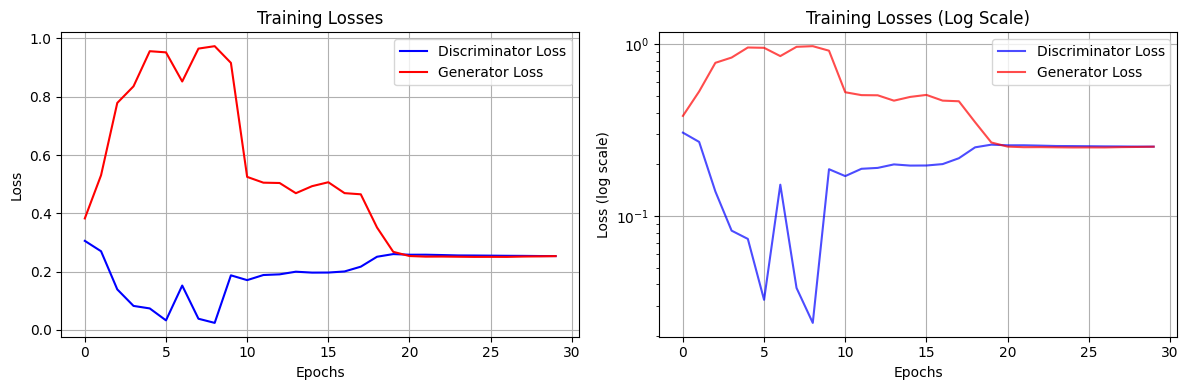

In [10]:
# 1. Loss Curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss', color='blue')
plt.plot(g_losses, label='Generator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(d_losses, label='Discriminator Loss', color='blue', alpha=0.7)
plt.plot(g_losses, label='Generator Loss', color='red', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Losses (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

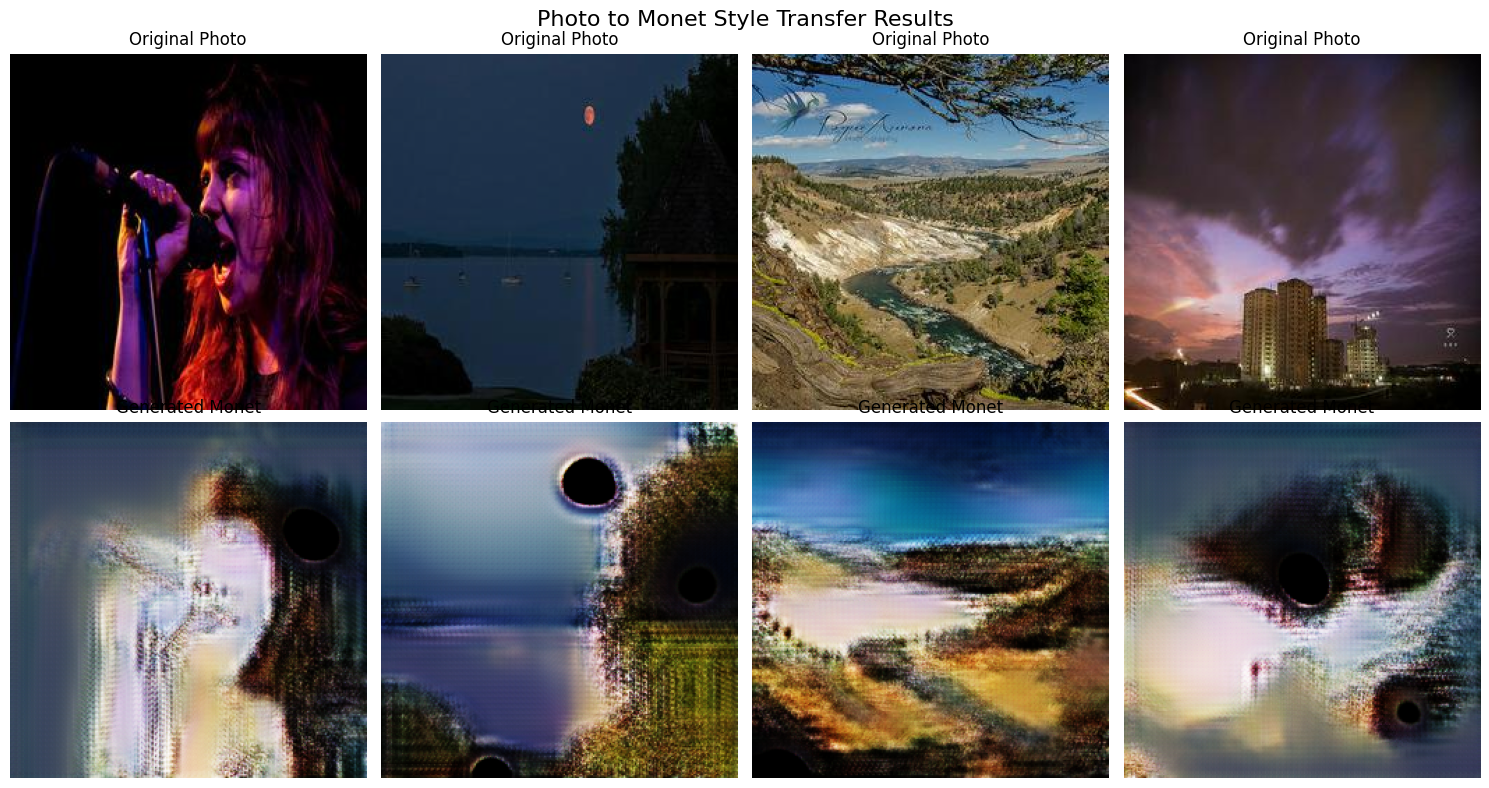

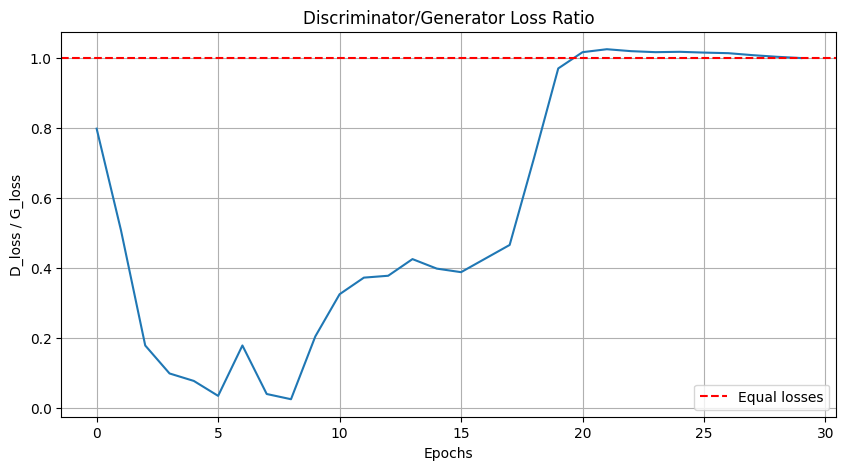

In [11]:
def visualize_results(generator, test_loader, device, num_samples=4):
    generator.eval()
    
    real_monet, real_photo = next(iter(test_loader))
    real_monet = real_monet[:num_samples].to(device)
    real_photo = real_photo[:num_samples].to(device)
    
    with torch.no_grad():
        fake_monet = generator(real_photo)
        xm.mark_step()
    
    # Move to CPU for visualization
    real_photo = real_photo.cpu()
    fake_monet = fake_monet.cpu()
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for i in range(num_samples):
        # Original photos
        axes[0, i].imshow(real_photo[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[0, i].set_title('Original Photo')
        axes[0, i].axis('off')
        
        # Generated Monet-style images
        axes[1, i].imshow(fake_monet[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[1, i].set_title('Generated Monet')
        axes[1, i].axis('off')
    
    plt.suptitle('Photo to Monet Style Transfer Results', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    generator.train()

# Call visualization after training
visualize_results(generator, test_loader, device)

# 3. Loss Ratio Analysis (useful for GAN stability)
plt.figure(figsize=(10, 5))
loss_ratio = [d/g if g != 0 else 0 for d, g in zip(d_losses, g_losses)]
plt.plot(loss_ratio)
plt.xlabel('Epochs')
plt.ylabel('D_loss / G_loss')
plt.title('Discriminator/Generator Loss Ratio')
plt.axhline(y=1, color='r', linestyle='--', label='Equal losses')
plt.legend()
plt.grid(True)
plt.show()

## Submission File
Finally we will create a submission file based on the instructions

In [12]:
import os
import zipfile
from PIL import Image
import numpy as np
from tqdm import tqdm

# Load all test photos (not just training data)
test_photo_path = os.path.join(data_root, 'photo_jpg')
test_photo_files = os.listdir(test_photo_path)
print(f"Total photos available: {len(test_photo_files)}")

def generate_submission_batch(generator, device, num_images=7000, batch_size=32):
    """Generate Monet-style images in batches for efficiency"""
    
    generator.eval()
    
    # Create dataset for all photos
    class PhotoDataset(Dataset):
        def __init__(self, photo_dir, transform):
            self.photo_files = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]
            self.transform = transform
            
        def __len__(self):
            return len(self.photo_files)
        
        def __getitem__(self, idx):
            photo = Image.open(self.photo_files[idx]).convert('RGB')
            return self.transform(photo), self.photo_files[idx]
    
    # Create dataloader
    photo_dataset = PhotoDataset(test_photo_path, transform)
    photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=False)
    
    # Generate images
    with zipfile.ZipFile('/kaggle/working/images.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        generated_count = 0
        
        while generated_count < num_images:
            for photos, _ in tqdm(photo_loader, desc="Generating batches"):
                if generated_count >= num_images:
                    break
                
                photos = photos.to(device)
                
                # Generate batch
                with torch.no_grad():
                    fake_monets = generator(photos)
                    if device.type == 'xla':
                        xm.mark_step()
                
                # Process each image in batch
                for i in range(fake_monets.size(0)):
                    if generated_count >= num_images:
                        break
                    
                    # Convert to image
                    fake_monet = fake_monets[i].cpu()
                    fake_monet = fake_monet * 0.5 + 0.5
                    fake_monet = fake_monet.clamp(0, 1)
                    
                    # Convert to PIL
                    fake_monet_np = fake_monet.permute(1, 2, 0).numpy()
                    fake_monet_np = (fake_monet_np * 255).astype(np.uint8)
                    fake_monet_pil = Image.fromarray(fake_monet_np)
                    
                    # Save to zip
                    image_name = f"monet_{generated_count:05d}.jpg"
                    temp_path = f"/tmp/{image_name}"
                    fake_monet_pil.save(temp_path, 'JPEG', quality=95)
                    zipf.write(temp_path, image_name)
                    os.remove(temp_path)
                    
                    generated_count += 1
    
    print(f"Successfully generated {generated_count} images!")
    return generated_count

# Use batch method for efficiency
num_generated = generate_submission_batch(
    generator=generator,
    device=device,
    num_images=7000,  # Can increase to 10000 if needed
    batch_size=16  # Adjust based on memory
)

# 5. Verify the submission
import zipfile
with zipfile.ZipFile('/kaggle/working/images.zip', 'r') as zipf:
    file_list = zipf.namelist()
    print(f"Total files in zip: {len(file_list)}")
    print(f"First 5 files: {file_list[:5]}")

Total photos available: 7038


Generating batches:   0%|          | 0/440 [00:00<?, ?it/s]

Generating batches:   0%|          | 1/440 [00:15<1:50:56, 15.16s/it]

Generating batches:   0%|          | 2/440 [00:15<47:05,  6.45s/it]  

Generating batches:   1%|          | 3/440 [00:15<26:39,  3.66s/it]

Generating batches:   1%|          | 4/440 [00:16<17:04,  2.35s/it]

Generating batches:   1%|          | 5/440 [00:16<11:45,  1.62s/it]

Generating batches:   1%|▏         | 6/440 [00:16<08:34,  1.18s/it]

Generating batches:   2%|▏         | 7/440 [00:17<06:32,  1.10it/s]

Generating batches:   2%|▏         | 8/440 [00:17<05:12,  1.38it/s]

Generating batches:   2%|▏         | 9/440 [00:17<04:19,  1.66it/s]

Generating batches:   2%|▏         | 10/440 [00:18<03:44,  1.92it/s]

Generating batches:   2%|▎         | 11/440 [00:18<03:19,  2.15it/s]

Generating batches:   3%|▎         | 12/440 [00:18<03:04,  2.31it/s]

Generating batches:   3%|▎         | 13/440 [00:19<02:50,  2.50it/s]

Generating batches:   3%|▎         | 14/440 [00:19<02:43,  2.60it/s]

Generating batches:   3%|▎         | 15/440 [00:19<02:36,  2.71it/s]

Generating batches:   4%|▎         | 16/440 [00:20<02:32,  2.79it/s]

Generating batches:   4%|▍         | 17/440 [00:20<02:27,  2.86it/s]

Generating batches:   4%|▍         | 18/440 [00:20<02:24,  2.91it/s]

Generating batches:   4%|▍         | 19/440 [00:21<02:22,  2.95it/s]

Generating batches:   5%|▍         | 20/440 [00:21<02:20,  2.98it/s]

Generating batches:   5%|▍         | 21/440 [00:21<02:19,  3.00it/s]

Generating batches:   5%|▌         | 22/440 [00:22<02:19,  3.00it/s]

Generating batches:   5%|▌         | 23/440 [00:22<02:19,  3.00it/s]

Generating batches:   5%|▌         | 24/440 [00:22<02:18,  3.01it/s]

Generating batches:   6%|▌         | 25/440 [00:23<02:17,  3.02it/s]

Generating batches:   6%|▌         | 26/440 [00:23<02:16,  3.03it/s]

Generating batches:   6%|▌         | 27/440 [00:23<02:16,  3.03it/s]

Generating batches:   6%|▋         | 28/440 [00:24<02:17,  2.99it/s]

Generating batches:   7%|▋         | 29/440 [00:24<02:20,  2.93it/s]

Generating batches:   7%|▋         | 30/440 [00:24<02:18,  2.97it/s]

Generating batches:   7%|▋         | 31/440 [00:25<02:16,  3.00it/s]

Generating batches:   7%|▋         | 32/440 [00:25<02:14,  3.03it/s]

Generating batches:   8%|▊         | 33/440 [00:25<02:13,  3.05it/s]

Generating batches:   8%|▊         | 34/440 [00:26<02:13,  3.05it/s]

Generating batches:   8%|▊         | 35/440 [00:26<02:12,  3.07it/s]

Generating batches:   8%|▊         | 36/440 [00:26<02:12,  3.04it/s]

Generating batches:   8%|▊         | 37/440 [00:27<02:11,  3.06it/s]

Generating batches:   9%|▊         | 38/440 [00:27<02:12,  3.04it/s]

Generating batches:   9%|▉         | 39/440 [00:27<02:11,  3.04it/s]

Generating batches:   9%|▉         | 40/440 [00:28<02:11,  3.04it/s]

Generating batches:   9%|▉         | 41/440 [00:28<02:12,  3.02it/s]

Generating batches:  10%|▉         | 42/440 [00:28<02:12,  3.00it/s]

Generating batches:  10%|▉         | 43/440 [00:29<02:13,  2.98it/s]

Generating batches:  10%|█         | 44/440 [00:29<02:15,  2.92it/s]

Generating batches:  10%|█         | 45/440 [00:29<02:15,  2.92it/s]

Generating batches:  10%|█         | 46/440 [00:30<02:15,  2.91it/s]

Generating batches:  11%|█         | 47/440 [00:30<02:13,  2.95it/s]

Generating batches:  11%|█         | 48/440 [00:30<02:12,  2.96it/s]

Generating batches:  11%|█         | 49/440 [00:31<02:10,  2.99it/s]

Generating batches:  11%|█▏        | 50/440 [00:31<02:11,  2.97it/s]

Generating batches:  12%|█▏        | 51/440 [00:31<02:09,  2.99it/s]

Generating batches:  12%|█▏        | 52/440 [00:32<02:09,  3.01it/s]

Generating batches:  12%|█▏        | 53/440 [00:32<02:07,  3.02it/s]

Generating batches:  12%|█▏        | 54/440 [00:32<02:07,  3.02it/s]

Generating batches:  12%|█▎        | 55/440 [00:33<02:07,  3.01it/s]

Generating batches:  13%|█▎        | 56/440 [00:33<02:07,  3.02it/s]

Generating batches:  13%|█▎        | 57/440 [00:33<02:09,  2.97it/s]

Generating batches:  13%|█▎        | 58/440 [00:34<02:07,  2.99it/s]

Generating batches:  13%|█▎        | 59/440 [00:34<02:08,  2.95it/s]

Generating batches:  14%|█▎        | 60/440 [00:34<02:07,  2.98it/s]

Generating batches:  14%|█▍        | 61/440 [00:35<02:07,  2.96it/s]

Generating batches:  14%|█▍        | 62/440 [00:35<02:05,  3.00it/s]

Generating batches:  14%|█▍        | 63/440 [00:35<02:05,  3.00it/s]

Generating batches:  15%|█▍        | 64/440 [00:36<02:06,  2.97it/s]

Generating batches:  15%|█▍        | 65/440 [00:36<02:05,  2.99it/s]

Generating batches:  15%|█▌        | 66/440 [00:36<02:04,  3.01it/s]

Generating batches:  15%|█▌        | 67/440 [00:37<02:05,  2.98it/s]

Generating batches:  15%|█▌        | 68/440 [00:37<02:03,  3.02it/s]

Generating batches:  16%|█▌        | 69/440 [00:37<02:03,  3.02it/s]

Generating batches:  16%|█▌        | 70/440 [00:38<02:02,  3.02it/s]

Generating batches:  16%|█▌        | 71/440 [00:38<02:01,  3.03it/s]

Generating batches:  16%|█▋        | 72/440 [00:38<02:00,  3.05it/s]

Generating batches:  17%|█▋        | 73/440 [00:39<02:00,  3.04it/s]

Generating batches:  17%|█▋        | 74/440 [00:39<02:02,  2.99it/s]

Generating batches:  17%|█▋        | 75/440 [00:39<02:01,  3.01it/s]

Generating batches:  17%|█▋        | 76/440 [00:40<02:00,  3.03it/s]

Generating batches:  18%|█▊        | 77/440 [00:40<02:00,  3.02it/s]

Generating batches:  18%|█▊        | 78/440 [00:40<01:59,  3.03it/s]

Generating batches:  18%|█▊        | 79/440 [00:41<01:58,  3.05it/s]

Generating batches:  18%|█▊        | 80/440 [00:41<01:57,  3.06it/s]

Generating batches:  18%|█▊        | 81/440 [00:41<01:59,  3.01it/s]

Generating batches:  19%|█▊        | 82/440 [00:42<01:58,  3.02it/s]

Generating batches:  19%|█▉        | 83/440 [00:42<01:59,  2.99it/s]

Generating batches:  19%|█▉        | 84/440 [00:42<01:59,  2.99it/s]

Generating batches:  19%|█▉        | 85/440 [00:43<01:57,  3.01it/s]

Generating batches:  20%|█▉        | 86/440 [00:43<01:57,  3.01it/s]

Generating batches:  20%|█▉        | 87/440 [00:43<01:56,  3.03it/s]

Generating batches:  20%|██        | 88/440 [00:44<01:54,  3.09it/s]

Generating batches:  20%|██        | 89/440 [00:44<01:53,  3.10it/s]

Generating batches:  20%|██        | 90/440 [00:44<01:52,  3.11it/s]

Generating batches:  21%|██        | 91/440 [00:45<01:52,  3.09it/s]

Generating batches:  21%|██        | 92/440 [00:45<01:51,  3.11it/s]

Generating batches:  21%|██        | 93/440 [00:45<01:50,  3.13it/s]

Generating batches:  21%|██▏       | 94/440 [00:46<01:50,  3.13it/s]

Generating batches:  22%|██▏       | 95/440 [00:46<01:49,  3.15it/s]

Generating batches:  22%|██▏       | 96/440 [00:46<01:48,  3.16it/s]

Generating batches:  22%|██▏       | 97/440 [00:47<01:49,  3.13it/s]

Generating batches:  22%|██▏       | 98/440 [00:47<01:49,  3.12it/s]

Generating batches:  22%|██▎       | 99/440 [00:47<01:48,  3.14it/s]

Generating batches:  23%|██▎       | 100/440 [00:47<01:48,  3.12it/s]

Generating batches:  23%|██▎       | 101/440 [00:48<01:48,  3.13it/s]

Generating batches:  23%|██▎       | 102/440 [00:48<01:48,  3.13it/s]

Generating batches:  23%|██▎       | 103/440 [00:48<01:47,  3.13it/s]

Generating batches:  24%|██▎       | 104/440 [00:49<01:48,  3.11it/s]

Generating batches:  24%|██▍       | 105/440 [00:49<01:49,  3.05it/s]

Generating batches:  24%|██▍       | 106/440 [00:49<01:48,  3.08it/s]

Generating batches:  24%|██▍       | 107/440 [00:50<01:47,  3.09it/s]

Generating batches:  25%|██▍       | 108/440 [00:50<01:47,  3.09it/s]

Generating batches:  25%|██▍       | 109/440 [00:50<01:47,  3.08it/s]

Generating batches:  25%|██▌       | 110/440 [00:51<01:46,  3.09it/s]

Generating batches:  25%|██▌       | 111/440 [00:51<01:46,  3.10it/s]

Generating batches:  25%|██▌       | 112/440 [00:51<01:45,  3.11it/s]

Generating batches:  26%|██▌       | 113/440 [00:52<01:46,  3.06it/s]

Generating batches:  26%|██▌       | 114/440 [00:52<01:46,  3.05it/s]

Generating batches:  26%|██▌       | 115/440 [00:52<01:46,  3.05it/s]

Generating batches:  26%|██▋       | 116/440 [00:53<01:46,  3.03it/s]

Generating batches:  27%|██▋       | 117/440 [00:53<01:46,  3.03it/s]

Generating batches:  27%|██▋       | 118/440 [00:53<01:47,  3.00it/s]

Generating batches:  27%|██▋       | 119/440 [00:54<01:46,  3.02it/s]

Generating batches:  27%|██▋       | 120/440 [00:54<01:45,  3.04it/s]

Generating batches:  28%|██▊       | 121/440 [00:54<01:46,  2.99it/s]

Generating batches:  28%|██▊       | 122/440 [00:55<01:46,  3.00it/s]

Generating batches:  28%|██▊       | 123/440 [00:55<01:46,  2.98it/s]

Generating batches:  28%|██▊       | 124/440 [00:55<01:46,  2.96it/s]

Generating batches:  28%|██▊       | 125/440 [00:56<01:46,  2.95it/s]

Generating batches:  29%|██▊       | 126/440 [00:56<01:46,  2.95it/s]

Generating batches:  29%|██▉       | 127/440 [00:56<01:44,  2.99it/s]

Generating batches:  29%|██▉       | 128/440 [00:57<01:42,  3.03it/s]

Generating batches:  29%|██▉       | 129/440 [00:57<01:42,  3.04it/s]

Generating batches:  30%|██▉       | 130/440 [00:57<01:41,  3.06it/s]

Generating batches:  30%|██▉       | 131/440 [00:58<01:40,  3.07it/s]

Generating batches:  30%|███       | 132/440 [00:58<01:40,  3.08it/s]

Generating batches:  30%|███       | 133/440 [00:58<01:39,  3.10it/s]

Generating batches:  30%|███       | 134/440 [00:59<01:38,  3.10it/s]

Generating batches:  31%|███       | 135/440 [00:59<01:38,  3.10it/s]

Generating batches:  31%|███       | 136/440 [00:59<01:40,  3.02it/s]

Generating batches:  31%|███       | 137/440 [01:00<01:40,  3.02it/s]

Generating batches:  31%|███▏      | 138/440 [01:00<01:39,  3.02it/s]

Generating batches:  32%|███▏      | 139/440 [01:00<01:38,  3.04it/s]

Generating batches:  32%|███▏      | 140/440 [01:01<01:38,  3.06it/s]

Generating batches:  32%|███▏      | 141/440 [01:01<01:37,  3.06it/s]

Generating batches:  32%|███▏      | 142/440 [01:01<01:37,  3.07it/s]

Generating batches:  32%|███▎      | 143/440 [01:02<01:36,  3.08it/s]

Generating batches:  33%|███▎      | 144/440 [01:02<01:36,  3.07it/s]

Generating batches:  33%|███▎      | 145/440 [01:02<01:35,  3.07it/s]

Generating batches:  33%|███▎      | 146/440 [01:03<01:36,  3.04it/s]

Generating batches:  33%|███▎      | 147/440 [01:03<01:36,  3.04it/s]

Generating batches:  34%|███▎      | 148/440 [01:03<01:35,  3.06it/s]

Generating batches:  34%|███▍      | 149/440 [01:04<01:34,  3.07it/s]

Generating batches:  34%|███▍      | 150/440 [01:04<01:33,  3.09it/s]

Generating batches:  34%|███▍      | 151/440 [01:04<01:34,  3.06it/s]

Generating batches:  35%|███▍      | 152/440 [01:05<01:33,  3.07it/s]

Generating batches:  35%|███▍      | 153/440 [01:05<01:33,  3.08it/s]

Generating batches:  35%|███▌      | 154/440 [01:05<01:32,  3.08it/s]

Generating batches:  35%|███▌      | 155/440 [01:06<01:32,  3.08it/s]

Generating batches:  35%|███▌      | 156/440 [01:06<01:31,  3.09it/s]

Generating batches:  36%|███▌      | 157/440 [01:06<01:32,  3.06it/s]

Generating batches:  36%|███▌      | 158/440 [01:06<01:31,  3.07it/s]

Generating batches:  36%|███▌      | 159/440 [01:07<01:31,  3.06it/s]

Generating batches:  36%|███▋      | 160/440 [01:07<01:31,  3.06it/s]

Generating batches:  37%|███▋      | 161/440 [01:07<01:30,  3.07it/s]

Generating batches:  37%|███▋      | 162/440 [01:08<01:31,  3.05it/s]

Generating batches:  37%|███▋      | 163/440 [01:08<01:30,  3.05it/s]

Generating batches:  37%|███▋      | 164/440 [01:08<01:30,  3.06it/s]

Generating batches:  38%|███▊      | 165/440 [01:09<01:29,  3.06it/s]

Generating batches:  38%|███▊      | 166/440 [01:09<01:29,  3.06it/s]

Generating batches:  38%|███▊      | 167/440 [01:09<01:29,  3.04it/s]

Generating batches:  38%|███▊      | 168/440 [01:10<01:29,  3.03it/s]

Generating batches:  38%|███▊      | 169/440 [01:10<01:28,  3.05it/s]

Generating batches:  39%|███▊      | 170/440 [01:10<01:29,  3.03it/s]

Generating batches:  39%|███▉      | 171/440 [01:11<01:29,  3.02it/s]

Generating batches:  39%|███▉      | 172/440 [01:11<01:28,  3.03it/s]

Generating batches:  39%|███▉      | 173/440 [01:11<01:27,  3.06it/s]

Generating batches:  40%|███▉      | 174/440 [01:12<01:27,  3.06it/s]

Generating batches:  40%|███▉      | 175/440 [01:12<01:26,  3.06it/s]

Generating batches:  40%|████      | 176/440 [01:12<01:26,  3.04it/s]

Generating batches:  40%|████      | 177/440 [01:13<01:26,  3.05it/s]

Generating batches:  40%|████      | 178/440 [01:13<01:26,  3.04it/s]

Generating batches:  41%|████      | 179/440 [01:13<01:25,  3.07it/s]

Generating batches:  41%|████      | 180/440 [01:14<01:24,  3.06it/s]

Generating batches:  41%|████      | 181/440 [01:14<01:24,  3.06it/s]

Generating batches:  41%|████▏     | 182/440 [01:14<01:26,  2.99it/s]

Generating batches:  42%|████▏     | 183/440 [01:15<01:25,  3.01it/s]

Generating batches:  42%|████▏     | 184/440 [01:15<01:24,  3.04it/s]

Generating batches:  42%|████▏     | 185/440 [01:15<01:24,  3.00it/s]

Generating batches:  42%|████▏     | 186/440 [01:16<01:26,  2.94it/s]

Generating batches:  42%|████▎     | 187/440 [01:16<01:25,  2.95it/s]

Generating batches:  43%|████▎     | 188/440 [01:16<01:25,  2.95it/s]

Generating batches:  43%|████▎     | 189/440 [01:17<01:24,  2.96it/s]

Generating batches:  43%|████▎     | 190/440 [01:17<01:24,  2.96it/s]

Generating batches:  43%|████▎     | 191/440 [01:17<01:23,  2.98it/s]

Generating batches:  44%|████▎     | 192/440 [01:18<01:22,  2.99it/s]

Generating batches:  44%|████▍     | 193/440 [01:18<01:22,  2.99it/s]

Generating batches:  44%|████▍     | 194/440 [01:18<01:21,  3.01it/s]

Generating batches:  44%|████▍     | 195/440 [01:19<01:21,  3.01it/s]

Generating batches:  45%|████▍     | 196/440 [01:19<01:20,  3.02it/s]

Generating batches:  45%|████▍     | 197/440 [01:19<01:21,  2.98it/s]

Generating batches:  45%|████▌     | 198/440 [01:20<01:20,  3.02it/s]

Generating batches:  45%|████▌     | 199/440 [01:20<01:19,  3.04it/s]

Generating batches:  45%|████▌     | 200/440 [01:20<01:19,  3.02it/s]

Generating batches:  46%|████▌     | 201/440 [01:21<01:19,  3.01it/s]

Generating batches:  46%|████▌     | 202/440 [01:21<01:18,  3.03it/s]

Generating batches:  46%|████▌     | 203/440 [01:21<01:18,  3.01it/s]

Generating batches:  46%|████▋     | 204/440 [01:22<01:17,  3.04it/s]

Generating batches:  47%|████▋     | 205/440 [01:22<01:17,  3.05it/s]

Generating batches:  47%|████▋     | 206/440 [01:22<01:16,  3.04it/s]

Generating batches:  47%|████▋     | 207/440 [01:23<01:16,  3.06it/s]

Generating batches:  47%|████▋     | 208/440 [01:23<01:15,  3.07it/s]

Generating batches:  48%|████▊     | 209/440 [01:23<01:15,  3.08it/s]

Generating batches:  48%|████▊     | 210/440 [01:24<01:14,  3.07it/s]

Generating batches:  48%|████▊     | 211/440 [01:24<01:14,  3.08it/s]

Generating batches:  48%|████▊     | 212/440 [01:24<01:15,  3.04it/s]

Generating batches:  48%|████▊     | 213/440 [01:25<01:14,  3.05it/s]

Generating batches:  49%|████▊     | 214/440 [01:25<01:14,  3.05it/s]

Generating batches:  49%|████▉     | 215/440 [01:25<01:13,  3.04it/s]

Generating batches:  49%|████▉     | 216/440 [01:26<01:13,  3.04it/s]

Generating batches:  49%|████▉     | 217/440 [01:26<01:13,  3.04it/s]

Generating batches:  50%|████▉     | 218/440 [01:26<01:13,  3.03it/s]

Generating batches:  50%|████▉     | 219/440 [01:27<01:13,  3.01it/s]

Generating batches:  50%|█████     | 220/440 [01:27<01:14,  2.97it/s]

Generating batches:  50%|█████     | 221/440 [01:27<01:13,  2.98it/s]

Generating batches:  50%|█████     | 222/440 [01:28<01:13,  2.97it/s]

Generating batches:  51%|█████     | 223/440 [01:28<01:12,  3.00it/s]

Generating batches:  51%|█████     | 224/440 [01:28<01:11,  3.03it/s]

Generating batches:  51%|█████     | 225/440 [01:29<01:10,  3.05it/s]

Generating batches:  51%|█████▏    | 226/440 [01:29<01:10,  3.04it/s]

Generating batches:  52%|█████▏    | 227/440 [01:29<01:09,  3.05it/s]

Generating batches:  52%|█████▏    | 228/440 [01:30<01:10,  3.02it/s]

Generating batches:  52%|█████▏    | 229/440 [01:30<01:09,  3.02it/s]

Generating batches:  52%|█████▏    | 230/440 [01:30<01:09,  3.03it/s]

Generating batches:  52%|█████▎    | 231/440 [01:31<01:08,  3.03it/s]

Generating batches:  53%|█████▎    | 232/440 [01:31<01:08,  3.04it/s]

Generating batches:  53%|█████▎    | 233/440 [01:31<01:07,  3.05it/s]

Generating batches:  53%|█████▎    | 234/440 [01:32<01:07,  3.05it/s]

Generating batches:  53%|█████▎    | 235/440 [01:32<01:06,  3.08it/s]

Generating batches:  54%|█████▎    | 236/440 [01:32<01:06,  3.06it/s]

Generating batches:  54%|█████▍    | 237/440 [01:33<01:07,  3.03it/s]

Generating batches:  54%|█████▍    | 238/440 [01:33<01:06,  3.04it/s]

Generating batches:  54%|█████▍    | 239/440 [01:33<01:05,  3.06it/s]

Generating batches:  55%|█████▍    | 240/440 [01:34<01:05,  3.07it/s]

Generating batches:  55%|█████▍    | 241/440 [01:34<01:05,  3.06it/s]

Generating batches:  55%|█████▌    | 242/440 [01:34<01:04,  3.08it/s]

Generating batches:  55%|█████▌    | 243/440 [01:35<01:05,  3.03it/s]

Generating batches:  55%|█████▌    | 244/440 [01:35<01:04,  3.03it/s]

Generating batches:  56%|█████▌    | 245/440 [01:35<01:03,  3.07it/s]

Generating batches:  56%|█████▌    | 246/440 [01:36<01:03,  3.06it/s]

Generating batches:  56%|█████▌    | 247/440 [01:36<01:03,  3.05it/s]

Generating batches:  56%|█████▋    | 248/440 [01:36<01:02,  3.06it/s]

Generating batches:  57%|█████▋    | 249/440 [01:37<01:03,  2.99it/s]

Generating batches:  57%|█████▋    | 250/440 [01:37<01:03,  3.01it/s]

Generating batches:  57%|█████▋    | 251/440 [01:37<01:02,  3.00it/s]

Generating batches:  57%|█████▋    | 252/440 [01:38<01:02,  3.02it/s]

Generating batches:  57%|█████▊    | 253/440 [01:38<01:02,  3.01it/s]

Generating batches:  58%|█████▊    | 254/440 [01:38<01:01,  3.02it/s]

Generating batches:  58%|█████▊    | 255/440 [01:38<01:00,  3.05it/s]

Generating batches:  58%|█████▊    | 256/440 [01:39<00:59,  3.07it/s]

Generating batches:  58%|█████▊    | 257/440 [01:39<00:59,  3.08it/s]

Generating batches:  59%|█████▊    | 258/440 [01:39<01:00,  3.01it/s]

Generating batches:  59%|█████▉    | 259/440 [01:40<01:00,  3.01it/s]

Generating batches:  59%|█████▉    | 260/440 [01:40<00:59,  3.02it/s]

Generating batches:  59%|█████▉    | 261/440 [01:40<00:58,  3.06it/s]

Generating batches:  60%|█████▉    | 262/440 [01:41<00:58,  3.07it/s]

Generating batches:  60%|█████▉    | 263/440 [01:41<00:57,  3.06it/s]

Generating batches:  60%|██████    | 264/440 [01:41<00:57,  3.07it/s]

Generating batches:  60%|██████    | 265/440 [01:42<00:57,  3.07it/s]

Generating batches:  60%|██████    | 266/440 [01:42<00:57,  3.05it/s]

Generating batches:  61%|██████    | 267/440 [01:42<00:56,  3.06it/s]

Generating batches:  61%|██████    | 268/440 [01:43<00:56,  3.04it/s]

Generating batches:  61%|██████    | 269/440 [01:43<00:56,  3.03it/s]

Generating batches:  61%|██████▏   | 270/440 [01:43<00:55,  3.05it/s]

Generating batches:  62%|██████▏   | 271/440 [01:44<00:55,  3.07it/s]

Generating batches:  62%|██████▏   | 272/440 [01:44<00:54,  3.07it/s]

Generating batches:  62%|██████▏   | 273/440 [01:44<00:54,  3.09it/s]

Generating batches:  62%|██████▏   | 274/440 [01:45<00:54,  3.06it/s]

Generating batches:  62%|██████▎   | 275/440 [01:45<00:54,  3.03it/s]

Generating batches:  63%|██████▎   | 276/440 [01:45<00:54,  3.03it/s]

Generating batches:  63%|██████▎   | 277/440 [01:46<00:54,  3.01it/s]

Generating batches:  63%|██████▎   | 278/440 [01:46<00:53,  3.02it/s]

Generating batches:  63%|██████▎   | 279/440 [01:46<00:54,  2.98it/s]

Generating batches:  64%|██████▎   | 280/440 [01:47<00:53,  3.01it/s]

Generating batches:  64%|██████▍   | 281/440 [01:47<00:52,  3.00it/s]

Generating batches:  64%|██████▍   | 282/440 [01:47<00:52,  3.04it/s]

Generating batches:  64%|██████▍   | 283/440 [01:48<00:51,  3.04it/s]

Generating batches:  65%|██████▍   | 284/440 [01:48<00:51,  3.01it/s]

Generating batches:  65%|██████▍   | 285/440 [01:48<00:52,  2.93it/s]

Generating batches:  65%|██████▌   | 286/440 [01:49<00:52,  2.93it/s]

Generating batches:  65%|██████▌   | 287/440 [01:49<00:51,  2.95it/s]

Generating batches:  65%|██████▌   | 288/440 [01:49<00:50,  3.01it/s]

Generating batches:  66%|██████▌   | 289/440 [01:50<00:50,  3.02it/s]

Generating batches:  66%|██████▌   | 290/440 [01:50<00:49,  3.01it/s]

Generating batches:  66%|██████▌   | 291/440 [01:50<00:49,  3.03it/s]

Generating batches:  66%|██████▋   | 292/440 [01:51<00:48,  3.04it/s]

Generating batches:  67%|██████▋   | 293/440 [01:51<00:48,  3.04it/s]

Generating batches:  67%|██████▋   | 294/440 [01:51<00:48,  3.01it/s]

Generating batches:  67%|██████▋   | 295/440 [01:52<00:47,  3.04it/s]

Generating batches:  67%|██████▋   | 296/440 [01:52<00:47,  3.03it/s]

Generating batches:  68%|██████▊   | 297/440 [01:52<00:47,  3.03it/s]

Generating batches:  68%|██████▊   | 298/440 [01:53<00:47,  3.02it/s]

Generating batches:  68%|██████▊   | 299/440 [01:53<00:46,  3.04it/s]

Generating batches:  68%|██████▊   | 300/440 [01:53<00:46,  3.01it/s]

Generating batches:  68%|██████▊   | 301/440 [01:54<00:46,  3.00it/s]

Generating batches:  69%|██████▊   | 302/440 [01:54<00:45,  3.01it/s]

Generating batches:  69%|██████▉   | 303/440 [01:54<00:45,  3.01it/s]

Generating batches:  69%|██████▉   | 304/440 [01:55<00:45,  2.98it/s]

Generating batches:  69%|██████▉   | 305/440 [01:55<00:44,  3.00it/s]

Generating batches:  70%|██████▉   | 306/440 [01:55<00:44,  3.03it/s]

Generating batches:  70%|██████▉   | 307/440 [01:56<00:43,  3.03it/s]

Generating batches:  70%|███████   | 308/440 [01:56<00:43,  3.06it/s]

Generating batches:  70%|███████   | 309/440 [01:56<00:42,  3.06it/s]

Generating batches:  70%|███████   | 310/440 [01:57<00:42,  3.08it/s]

Generating batches:  71%|███████   | 311/440 [01:57<00:41,  3.09it/s]

Generating batches:  71%|███████   | 312/440 [01:57<00:41,  3.08it/s]

Generating batches:  71%|███████   | 313/440 [01:58<00:41,  3.09it/s]

Generating batches:  71%|███████▏  | 314/440 [01:58<00:40,  3.09it/s]

Generating batches:  72%|███████▏  | 315/440 [01:58<00:40,  3.09it/s]

Generating batches:  72%|███████▏  | 316/440 [01:59<00:39,  3.10it/s]

Generating batches:  72%|███████▏  | 317/440 [01:59<00:39,  3.12it/s]

Generating batches:  72%|███████▏  | 318/440 [01:59<00:38,  3.14it/s]

Generating batches:  72%|███████▎  | 319/440 [02:00<00:39,  3.10it/s]

Generating batches:  73%|███████▎  | 320/440 [02:00<00:39,  3.06it/s]

Generating batches:  73%|███████▎  | 321/440 [02:00<00:39,  3.05it/s]

Generating batches:  73%|███████▎  | 322/440 [02:01<00:38,  3.06it/s]

Generating batches:  73%|███████▎  | 323/440 [02:01<00:38,  3.04it/s]

Generating batches:  74%|███████▎  | 324/440 [02:01<00:38,  3.05it/s]

Generating batches:  74%|███████▍  | 325/440 [02:02<00:37,  3.07it/s]

Generating batches:  74%|███████▍  | 326/440 [02:02<00:37,  3.04it/s]

Generating batches:  74%|███████▍  | 327/440 [02:02<00:36,  3.07it/s]

Generating batches:  75%|███████▍  | 328/440 [02:03<00:36,  3.05it/s]

Generating batches:  75%|███████▍  | 329/440 [02:03<00:36,  3.08it/s]

Generating batches:  75%|███████▌  | 330/440 [02:03<00:35,  3.08it/s]

Generating batches:  75%|███████▌  | 331/440 [02:03<00:35,  3.10it/s]

Generating batches:  75%|███████▌  | 332/440 [02:04<00:34,  3.12it/s]

Generating batches:  76%|███████▌  | 333/440 [02:04<00:34,  3.13it/s]

Generating batches:  76%|███████▌  | 334/440 [02:04<00:33,  3.12it/s]

Generating batches:  76%|███████▌  | 335/440 [02:05<00:33,  3.09it/s]

Generating batches:  76%|███████▋  | 336/440 [02:05<00:33,  3.10it/s]

Generating batches:  77%|███████▋  | 337/440 [02:05<00:33,  3.11it/s]

Generating batches:  77%|███████▋  | 338/440 [02:06<00:32,  3.14it/s]

Generating batches:  77%|███████▋  | 339/440 [02:06<00:32,  3.15it/s]

Generating batches:  77%|███████▋  | 340/440 [02:06<00:31,  3.16it/s]

Generating batches:  78%|███████▊  | 341/440 [02:07<00:31,  3.15it/s]

Generating batches:  78%|███████▊  | 342/440 [02:07<00:31,  3.16it/s]

Generating batches:  78%|███████▊  | 343/440 [02:07<00:30,  3.15it/s]

Generating batches:  78%|███████▊  | 344/440 [02:08<00:30,  3.15it/s]

Generating batches:  78%|███████▊  | 345/440 [02:08<00:30,  3.16it/s]

Generating batches:  79%|███████▊  | 346/440 [02:08<00:29,  3.14it/s]

Generating batches:  79%|███████▉  | 347/440 [02:09<00:29,  3.15it/s]

Generating batches:  79%|███████▉  | 348/440 [02:09<00:29,  3.14it/s]

Generating batches:  79%|███████▉  | 349/440 [02:09<00:28,  3.16it/s]

Generating batches:  80%|███████▉  | 350/440 [02:10<00:28,  3.17it/s]

Generating batches:  80%|███████▉  | 351/440 [02:10<00:28,  3.10it/s]

Generating batches:  80%|████████  | 352/440 [02:10<00:28,  3.14it/s]

Generating batches:  80%|████████  | 353/440 [02:10<00:27,  3.15it/s]

Generating batches:  80%|████████  | 354/440 [02:11<00:27,  3.09it/s]

Generating batches:  81%|████████  | 355/440 [02:11<00:27,  3.12it/s]

Generating batches:  81%|████████  | 356/440 [02:11<00:26,  3.13it/s]

Generating batches:  81%|████████  | 357/440 [02:12<00:26,  3.14it/s]

Generating batches:  81%|████████▏ | 358/440 [02:12<00:26,  3.13it/s]

Generating batches:  82%|████████▏ | 359/440 [02:12<00:26,  3.11it/s]

Generating batches:  82%|████████▏ | 360/440 [02:13<00:25,  3.10it/s]

Generating batches:  82%|████████▏ | 361/440 [02:13<00:25,  3.10it/s]

Generating batches:  82%|████████▏ | 362/440 [02:13<00:25,  3.10it/s]

Generating batches:  82%|████████▎ | 363/440 [02:14<00:24,  3.10it/s]

Generating batches:  83%|████████▎ | 364/440 [02:14<00:24,  3.11it/s]

Generating batches:  83%|████████▎ | 365/440 [02:14<00:24,  3.10it/s]

Generating batches:  83%|████████▎ | 366/440 [02:15<00:23,  3.12it/s]

Generating batches:  83%|████████▎ | 367/440 [02:15<00:24,  3.02it/s]

Generating batches:  84%|████████▎ | 368/440 [02:15<00:23,  3.05it/s]

Generating batches:  84%|████████▍ | 369/440 [02:16<00:23,  3.04it/s]

Generating batches:  84%|████████▍ | 370/440 [02:16<00:22,  3.07it/s]

Generating batches:  84%|████████▍ | 371/440 [02:16<00:22,  3.05it/s]

Generating batches:  85%|████████▍ | 372/440 [02:17<00:22,  3.05it/s]

Generating batches:  85%|████████▍ | 373/440 [02:17<00:21,  3.06it/s]

Generating batches:  85%|████████▌ | 374/440 [02:17<00:21,  3.04it/s]

Generating batches:  85%|████████▌ | 375/440 [02:18<00:21,  3.06it/s]

Generating batches:  85%|████████▌ | 376/440 [02:18<00:21,  3.05it/s]

Generating batches:  86%|████████▌ | 377/440 [02:18<00:20,  3.07it/s]

Generating batches:  86%|████████▌ | 378/440 [02:19<00:20,  3.06it/s]

Generating batches:  86%|████████▌ | 379/440 [02:19<00:19,  3.06it/s]

Generating batches:  86%|████████▋ | 380/440 [02:19<00:19,  3.07it/s]

Generating batches:  87%|████████▋ | 381/440 [02:20<00:19,  3.09it/s]

Generating batches:  87%|████████▋ | 382/440 [02:20<00:19,  3.03it/s]

Generating batches:  87%|████████▋ | 383/440 [02:20<00:18,  3.04it/s]

Generating batches:  87%|████████▋ | 384/440 [02:21<00:18,  3.07it/s]

Generating batches:  88%|████████▊ | 385/440 [02:21<00:18,  3.05it/s]

Generating batches:  88%|████████▊ | 386/440 [02:21<00:17,  3.06it/s]

Generating batches:  88%|████████▊ | 387/440 [02:22<00:17,  3.04it/s]

Generating batches:  88%|████████▊ | 388/440 [02:22<00:17,  3.06it/s]

Generating batches:  88%|████████▊ | 389/440 [02:22<00:16,  3.08it/s]

Generating batches:  89%|████████▊ | 390/440 [02:23<00:16,  3.08it/s]

Generating batches:  89%|████████▉ | 391/440 [02:23<00:16,  3.06it/s]

Generating batches:  89%|████████▉ | 392/440 [02:23<00:15,  3.08it/s]

Generating batches:  89%|████████▉ | 393/440 [02:24<00:15,  3.06it/s]

Generating batches:  90%|████████▉ | 394/440 [02:24<00:15,  3.03it/s]

Generating batches:  90%|████████▉ | 395/440 [02:24<00:14,  3.05it/s]

Generating batches:  90%|█████████ | 396/440 [02:24<00:14,  3.07it/s]

Generating batches:  90%|█████████ | 397/440 [02:25<00:14,  3.03it/s]

Generating batches:  90%|█████████ | 398/440 [02:25<00:13,  3.05it/s]

Generating batches:  91%|█████████ | 399/440 [02:25<00:13,  3.07it/s]

Generating batches:  91%|█████████ | 400/440 [02:26<00:13,  3.07it/s]

Generating batches:  91%|█████████ | 401/440 [02:26<00:12,  3.10it/s]

Generating batches:  91%|█████████▏| 402/440 [02:26<00:12,  3.09it/s]

Generating batches:  92%|█████████▏| 403/440 [02:27<00:11,  3.11it/s]

Generating batches:  92%|█████████▏| 404/440 [02:27<00:11,  3.11it/s]

Generating batches:  92%|█████████▏| 405/440 [02:27<00:11,  3.13it/s]

Generating batches:  92%|█████████▏| 406/440 [02:28<00:10,  3.13it/s]

Generating batches:  92%|█████████▎| 407/440 [02:28<00:10,  3.13it/s]

Generating batches:  93%|█████████▎| 408/440 [02:28<00:10,  3.13it/s]

Generating batches:  93%|█████████▎| 409/440 [02:29<00:10,  3.10it/s]

Generating batches:  93%|█████████▎| 410/440 [02:29<00:09,  3.08it/s]

Generating batches:  93%|█████████▎| 411/440 [02:29<00:09,  3.08it/s]

Generating batches:  94%|█████████▎| 412/440 [02:30<00:09,  3.08it/s]

Generating batches:  94%|█████████▍| 413/440 [02:30<00:08,  3.01it/s]

Generating batches:  94%|█████████▍| 414/440 [02:30<00:08,  3.01it/s]

Generating batches:  94%|█████████▍| 415/440 [02:31<00:08,  3.03it/s]

Generating batches:  95%|█████████▍| 416/440 [02:31<00:07,  3.06it/s]

Generating batches:  95%|█████████▍| 417/440 [02:31<00:07,  3.02it/s]

Generating batches:  95%|█████████▌| 418/440 [02:32<00:07,  3.04it/s]

Generating batches:  95%|█████████▌| 419/440 [02:32<00:06,  3.07it/s]

Generating batches:  95%|█████████▌| 420/440 [02:32<00:06,  3.10it/s]

Generating batches:  96%|█████████▌| 421/440 [02:33<00:06,  3.11it/s]

Generating batches:  96%|█████████▌| 422/440 [02:33<00:05,  3.13it/s]

Generating batches:  96%|█████████▌| 423/440 [02:33<00:05,  3.15it/s]

Generating batches:  96%|█████████▋| 424/440 [02:34<00:05,  3.15it/s]

Generating batches:  97%|█████████▋| 425/440 [02:34<00:04,  3.14it/s]

Generating batches:  97%|█████████▋| 426/440 [02:34<00:04,  3.12it/s]

Generating batches:  97%|█████████▋| 427/440 [02:35<00:04,  3.12it/s]

Generating batches:  97%|█████████▋| 428/440 [02:35<00:03,  3.13it/s]

Generating batches:  98%|█████████▊| 429/440 [02:35<00:03,  3.09it/s]

Generating batches:  98%|█████████▊| 430/440 [02:36<00:03,  3.03it/s]

Generating batches:  98%|█████████▊| 431/440 [02:36<00:02,  3.01it/s]

Generating batches:  98%|█████████▊| 432/440 [02:36<00:02,  3.02it/s]

Generating batches:  98%|█████████▊| 433/440 [02:37<00:02,  3.03it/s]

Generating batches:  99%|█████████▊| 434/440 [02:37<00:01,  3.03it/s]

Generating batches:  99%|█████████▉| 435/440 [02:37<00:01,  3.05it/s]

Generating batches:  99%|█████████▉| 436/440 [02:37<00:01,  3.07it/s]

Generating batches:  99%|█████████▉| 437/440 [02:38<00:00,  3.06it/s]

Generating batches: 100%|█████████▉| 438/440 [02:38<00:00,  3.25it/s]

Generating batches: 100%|█████████▉| 438/440 [02:38<00:00,  2.76it/s]

Successfully generated 7000 images!


Total files in zip: 7000
First 5 files: ['monet_00000.jpg', 'monet_00001.jpg', 'monet_00002.jpg', 'monet_00003.jpg', 'monet_00004.jpg']


## Conclusion
This notebook successfully takes Monet image input, creates a generator and a discriminator to be trained against each other, and optimizers these models to create a more accurate output. This project was more difficult due to the very long runtime and reliance on TPU. In my opinion, the way to improve this notebook is to get a more robust system that can handle more training time and different tries training models.